### Prediction of Shipment Cost at DB Schenker

**Introduction**

DB Schenker is one of the world's leading provider of logistics services. It supports the global exchange of goods through worldwide air and sea freight, contract logistics and supply chain management. It pursue a future oriented data strategy and implement the data driven business models. 
The dispatchers receive shipments orders and find suitable carriers for the land transport. This relies on human decisions, interactions and many more parameters and hence complex. Price predition can be used as a guidline and can be predicted by using a trained AI/ML model.

**Goal of the Project**

To build an accurate ML model to predict the shipping costs of the transport using the land transport data.

**The Problem and Matric Selection**

Prediction of the shipping cost is a regression problem and the matrics Mean absolute error, Mean squared error, and Root mean squared error can be used to solve this.

**Structure of the notebook**

1. Loading the Data and Packages
2. Exploring the data
3. Cleaning Data
4. Analyzing the test Variable (Cost)
5. Feature Engineering
6. Data Manipulation
7. Modelling
8. Model Selection
9. Preprocessing of the given test data 
10. The prediction of the test data
11. Summary
12. Outlook

### 1. Importing the Libraries

In [84]:
import pandas as pd # data handling
import numpy as np

from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr 
from scipy.stats import norm
import geopy.distance

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_3033/3608387684.py:6: DeprecationWarning:

Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.



**Loading the data**

In [7]:
df_train = pd.read_csv("data/train_data.csv", sep = ";")

### 2. Exploring the data

In [85]:
# reading the data set
df_train.head(10)

In [10]:
#Checking for how many rows and columns
df_train.shape

(251155, 9)

There are 251155 rows and 9 columns in the dataframe.

In [11]:
#Checking for the column names
df_train.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr',
       'shipping_date', 'cost'],
      dtype='object')

In [12]:
#Checking for null values in each column
df_train.isnull().sum()

origin_latitude          0
origin_longitude         0
destination_latitude     0
destination_longitude    0
weight                   0
loading_meters           0
is_adr                   0
shipping_date            0
cost                     0
dtype: int64

The above results shows that there are no null values.

In [13]:
# Checking for type of data present in the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251155 entries, 0 to 251154
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   origin_latitude        251155 non-null  float64
 1   origin_longitude       251155 non-null  float64
 2   destination_latitude   251155 non-null  float64
 3   destination_longitude  251155 non-null  float64
 4   weight                 251155 non-null  float64
 5   loading_meters         251155 non-null  float64
 6   is_adr                 251155 non-null  bool   
 7   shipping_date          251155 non-null  object 
 8   cost                   251155 non-null  float64
dtypes: bool(1), float64(7), object(1)
memory usage: 15.6+ MB


The information shows that except the variable "is_adr" (is it a dangerous good?), all other variables are in float form.

In [14]:
# Checking for unique values
df_train.nunique()

origin_latitude          776
origin_longitude         912
destination_latitude     803
destination_longitude    978
weight                   582
loading_meters           310
is_adr                     1
shipping_date            731
cost                     979
dtype: int64

In [15]:
# Finding the descriptive statistics
df_train.describe()

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,cost
count,"251,155.00","251,155.00","251,155.00","251,155.00","251,155.00","251,155.00","251,155.00"
mean,25.70,108.93,25.58,108.97,0.41,0.17,0.34
std,1.78,2.09,1.98,2.30,0.13,0.06,0.13
min,21.71,102.97,21.65,103.00,0.05,0.00,0.02
25%,24.31,107.34,23.78,107.18,0.33,0.20,0.25
50%,25.65,108.89,25.64,109.40,0.47,0.20,0.33
75%,26.91,110.46,27.17,110.75,0.49,0.20,0.41
max,30.22,114.21,30.40,114.25,1.00,0.99,2.35


The mean value of the cost is 0.34. 

In [16]:
bool_features=df_train[['is_adr']]
bool_features.describe()

,is_adr
count,251155
unique,1
top,True
freq,251155


### 3. Cleaning the data

**Changing the variable "is_adr" from Boolean values to integer**

Changing the boolean value to numeric will help for further visualization and analysis

In [17]:
df_train["is_adr"] = df_train["is_adr"].astype(int)

**Changing Time to datetime stamp**

In [18]:
df_train['shipping_date'] = pd.to_datetime(df_train['shipping_date'], format='%Y-%m-%d')

**Extracting year, month, and day from the date column**

In [20]:
df_train = df_train.assign(
    timestamp = lambda x: pd.to_datetime(x['shipping_date']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofweek = lambda x: x['shipping_date'].dt.dayofweek
)

In [21]:
df_train.head(2)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost,timestamp,year,month,day,dayofweek
0,27.22,105.59,26.91,108.67,0.51,0.20,1,2017-04-24,0.25,2017-04-24,2017,4,24,0
1,25.00,109.79,25.34,108.59,0.48,0.20,1,2017-07-27,0.25,2017-07-27,2017,7,27,3


### 4. Analysing the data

Due to the uploading issues to github, the geographical plots are saved in the image folder.

Where is the Origin of shipment (Country) takeplace?

In [83]:
# Geographical Plot
fig = px.scatter_mapbox(df_train, lat="origin_latitude", lon="origin_longitude", color="cost", center={'lat':25.47, 'lon':108.51},
                        zoom=4, height=400, width=800, title="Cost in Origin place")
# earth background
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":50})

fig.show()
#fig.write_image("images/map1.png")

The geographical map shows that the origin of the shipment is obtained from China.

Where is the destination of shipment (Country) takeplace?

In [82]:
fig = px.scatter_mapbox(df_train, lat="destination_latitude", lon="destination_longitude", color="cost", center={'lat':25.47, 'lon':108.51},
                        zoom=4, height=400, width=800, title="Cost in Delivery place")
# earth background

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":50})
#fig.write_image("images/map2.png")

This geographical map also shows that the destination of the shipment is in China.

**Exploring the relationship between variables using pair plots** 

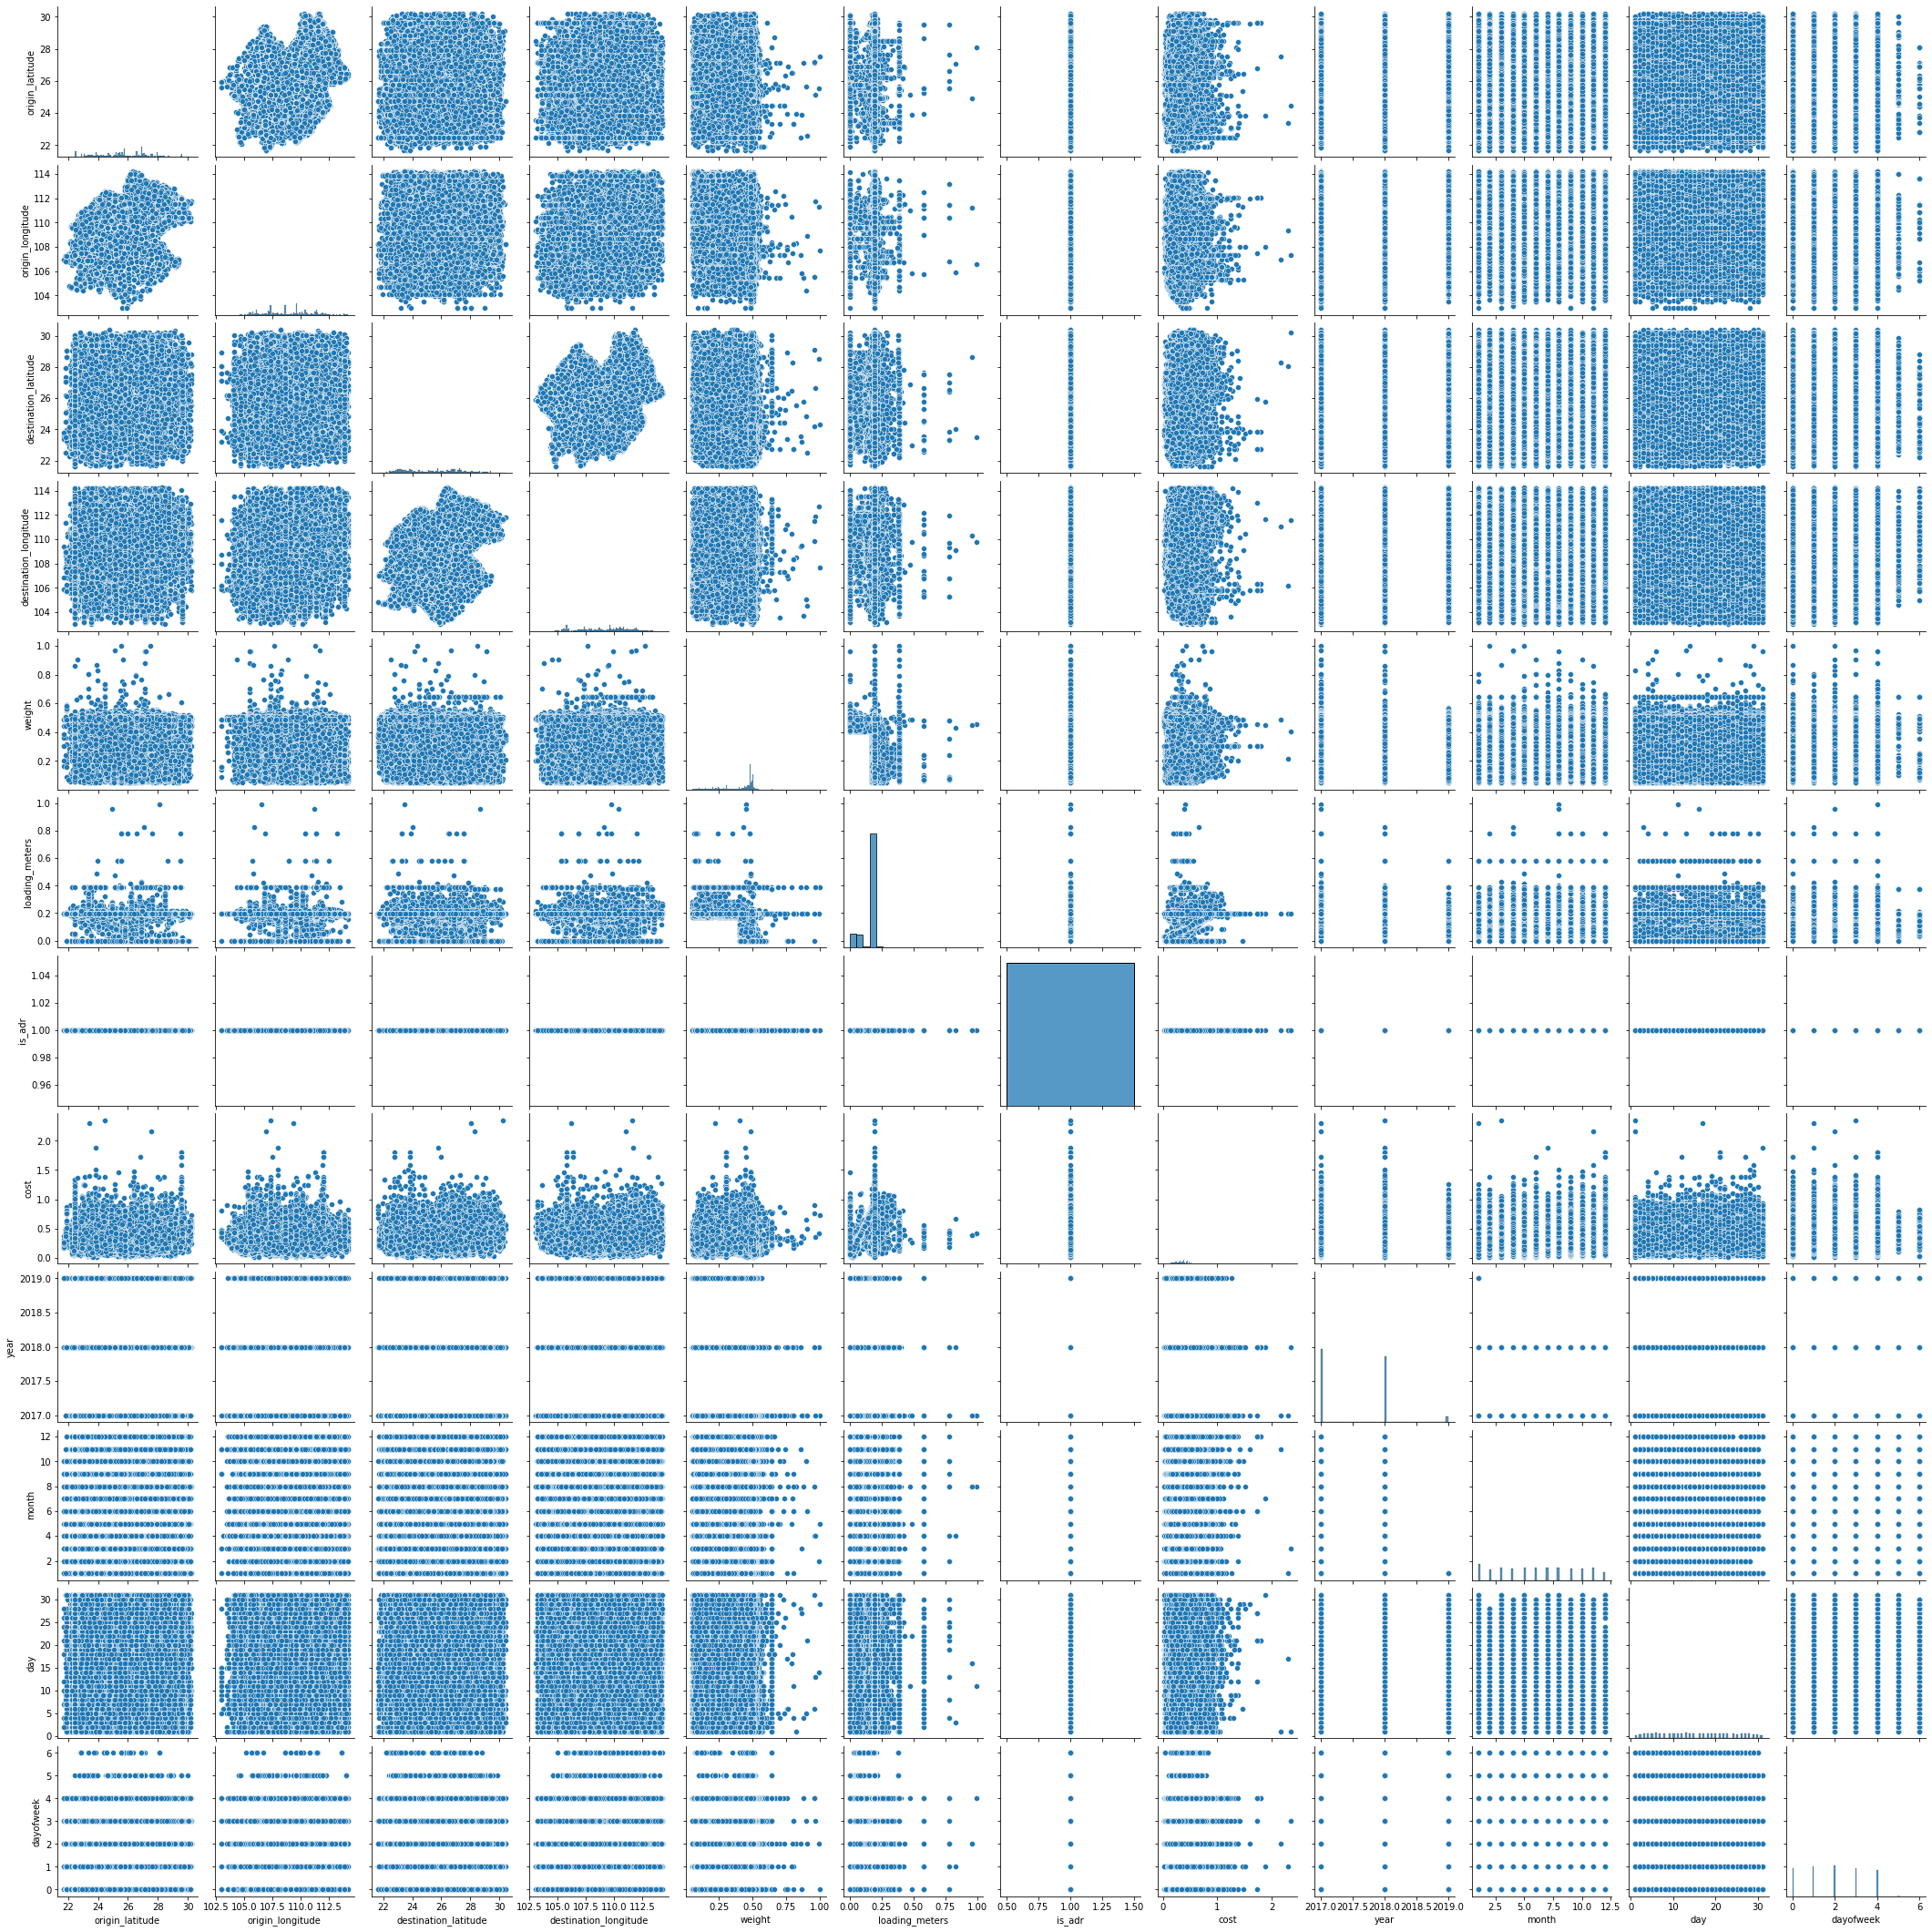

In [24]:
sns.pairplot(df_train)

The pairplot shows the variations in each plot. The plots are in matrix format where the row name represents x axis and column name represents the y axis. The main-diagonal subplots are the univariate histograms (distributions) for each attribute.

Pair plot is used to understand the best set of features to explain a relationship between two variables or the  separated clusters. It also helps to form some simple classification models by drawing some simple lines or make linear separation in our data-set.


**Daily Shipping Cost**

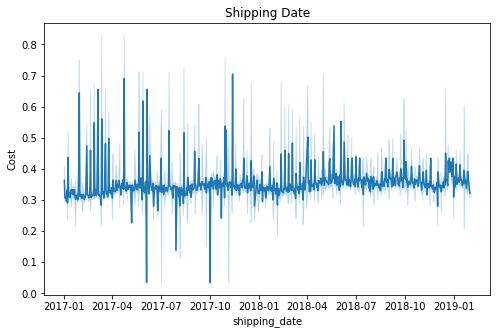

In [25]:
fig, ax = plt.subplots()
sns.lineplot(x=df_train['shipping_date'], y=df_train['cost'] , data=df_train, ax=ax)
ax.set(title='Shipping Date', ylabel=r'Cost');

From the above graph the daily shipping cost shows that most of the value falls between 0.3 and 0.35. The lowest cost was recorded in October 2017 and the highest cost recorded in March 2017.

**Yearly Shipping Cost**

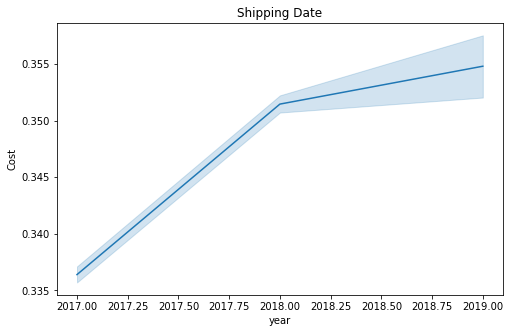

In [26]:
fig, ax = plt.subplots()
sns.lineplot(x=df_train['year'], y=df_train['cost'] , data=df_train, ax=ax)
ax.set(title='Shipping Date', ylabel=r'Cost');

Yearly shipping cost shows that there is an increase in the cost every year and the cost is maximum in 2019

**Monthly Shipping Cost**

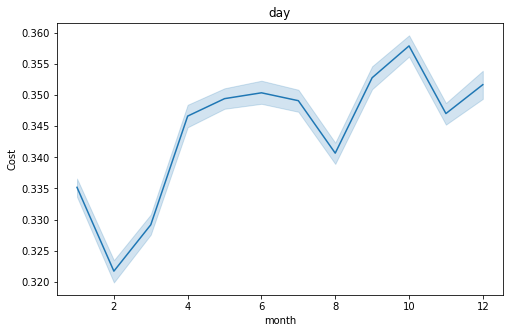

In [27]:
fig, ax = plt.subplots()
sns.lineplot(x=df_train['month'], y=df_train['cost'] , data=df_train, ax=ax)
ax.set(title='day', ylabel=r'Cost');

Monthly cost shows no clear trend like continuously increasing or decreasing.

### Distribution of Cost

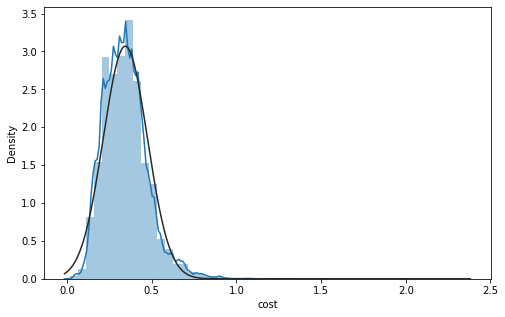

In [96]:
sns.distplot(df_train['cost'], fit=norm);

The distribution of cost curve shows that the cost variable is slightly right skewed.

**Comparing Weight and Cost**

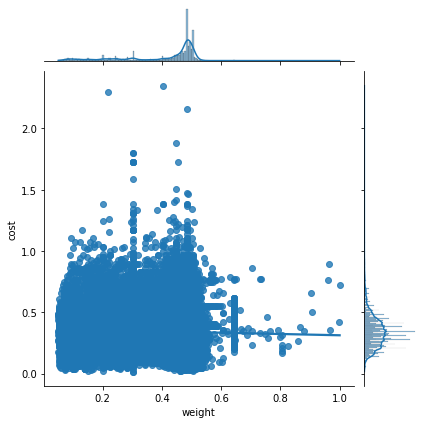

In [31]:
# Weight vs Cost
sns.jointplot(x=df_train['weight'], y=df_train['cost'], kind='reg')

The plot shows that most of the shipments are between 0.05 - 0.6 kg approaximately and there is not much linearity between the weight and cost. 

**Comparing Length of the shipment to Cost**

<AxesSubplot:xlabel='loading_meters', ylabel='cost'>

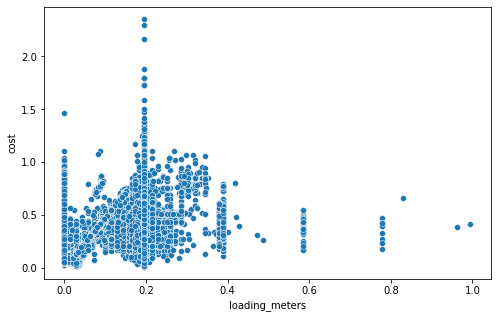

In [ ]:
sns.scatterplot(data=df_train, x="loading_meters", y="cost")

The scatter plot of the distance between the length of the shipment and cost also shows that there is no linear relationship between them. But there are some concrete values approaximately around 0.01, 0.2, 0.39, 0.59 and 0.79. This shows that at these values costs are increasing.

### 5. Feature Engineering

As the distance between the origin of shipment and destination of shipment can influence the cost of shipping, to create a new column called "Distance" which is the difference of longitude and lattitude of origin of shipment between that of the destination would be good.

In [32]:
df_train['Distance']=[round(geopy.distance.distance((df_train.origin_latitude[i], df_train.origin_longitude[i]),(df_train.destination_latitude[i], df_train.destination_longitude[i])).m,2) for i in df_train.index]

In [33]:
df_train.head(2)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost,timestamp,year,month,day,dayofweek,Distance
0,27.22,105.59,26.91,108.67,0.51,0.20,1,2017-04-24,0.25,2017-04-24,2017,4,24,0,"307,445.69"
1,25.00,109.79,25.34,108.59,0.48,0.20,1,2017-07-27,0.25,2017-07-27,2017,7,27,3,"126,699.74"


**Feature Selection**

As there is columns of year, month, day and day of the year,  the unnecessary columns timestamp and shipping data can be dropped.

In [34]:
df_train.drop(["timestamp", "shipping_date"], axis=1, inplace=True)

In [35]:
df_train.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr', 'cost',
       'year', 'month', 'day', 'dayofweek', 'Distance'],
      dtype='object')

**Correlation heat map**

Correlation heatmaps are used to find the relationships between variables and to understand the strength of these relationships. 

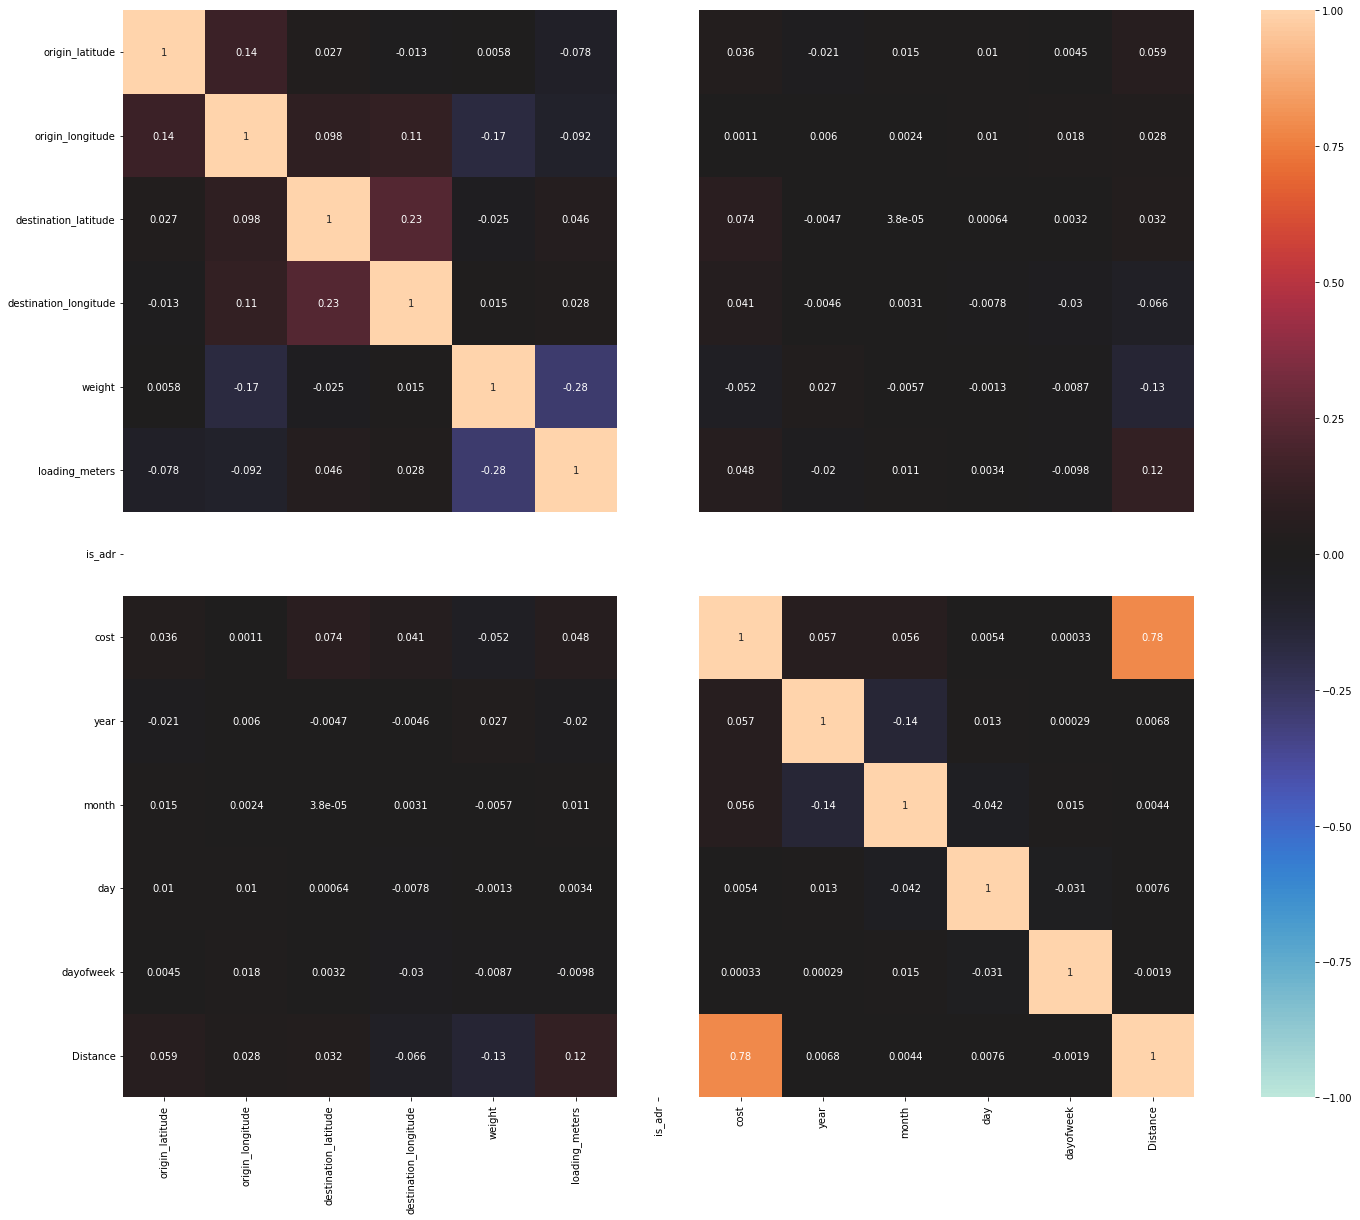

In [36]:
plt.figure(figsize=[24,20])
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

The correlation graph shows there are longitude and lattitude varibles are highly correlated. 

### 6. Data Manipulation

In [37]:
#Splitting the data intro training & testing sets

y = df_train['cost']
X = df_train.drop('cost', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Original dataset  ---> ',X.shape,y.shape,'\nTraining set  ---> ', X_train.shape,y_train.shape,
'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original dataset  --->  (251155, 12) (251155,) 
Training set  --->  (200924, 12) (200924,) 
Testing set   --->  (50231, 12)  (50231,)


**Feature Scaling (Standardization)**

As the fields weight, loading_meters and cost have already normalized, these fields are avoided from scaling and normalization.
So here the column "Distance" is normalised.

In [38]:
# Standardization using standard scalar
col_scale = ['Distance']
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

In [39]:
# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

In [40]:
print('Original dataset  ---> ',X.shape,y.shape,'\nTraining set  ---> ', X_train_preprocessed.shape,y_train.shape,
'\nTesting set   ---> ', X_test_preprocessed.shape,'', y_test.shape)

Original dataset  --->  (251155, 12) (251155,) 
Training set  --->  (200924, 12) (200924,) 
Testing set   --->  (50231, 12)  (50231,)


### Evaluation Metric Selection

Mean absolute error, Mean squared error are Root mean squared error selected as metrics for model evaluation.

### 7. Modelling

In this modelling part, there are mainely 3 models are used. Linear regression, Random Forest and Light Gradient Boosting Model (LGBM) models are used

### Linear Regression model with statsmodels

Multivariate Linear Regression Model

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
# Instantiate our model 
lin_reg = LinearRegression()

# Train the model using our data
lin_reg.fit(X_train_preprocessed, y_train)

LinearRegression()

In [43]:
#intercept
lin_reg.intercept_

-27.421944839625816

In [44]:
# Coefficient
lin_reg.coef_

array([ 1.03557776e-01, -6.71435488e-04, -2.10598651e-03,  2.15659712e-03,
        5.15497093e-03,  3.14316013e-02, -8.91052916e-02, -1.73472348e-16,
        1.35722372e-02,  2.31437988e-03,  2.85945125e-05,  4.35232962e-04])

In [86]:
#Prediction
y_pred = lin_reg.predict(X_test)

In [46]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

        Actual  Predicted
231756    0.31     256.66
100391    0.37     158.35
25222     0.53     261.58
115610    0.36      93.70
66738     0.51      61.24
...        ...        ...
83659     0.39     175.63
194385    0.44     240.20
24511     0.14      31.59
95899     0.41     273.30
127998    0.21     120.27

[50231 rows x 2 columns]


**Evaluating the Multivariate Model**


In [47]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 135.58
Mean squared error: 24753.90
Root mean squared error: 157.33


Here the MSE, MAE and RMSE show that the linear regression model did not fit.

### Random Forest (RF)

RF can perform both regression and classification tasks. 
RF can handle large datasets efficiently and it provides a higher level of accuracy in predicting outcomes over the decision tree algorithm.

In [48]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_jobs = -1, random_state = 42, n_estimators = 500, verbose = 1)
regr.fit(X_train_preprocessed, y_train)
regr.score(X_train_preprocessed, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   27.3s finished


0.9728524915799112

In [87]:
#from sklearn import metrics
pred1 = regr.predict(X_test) 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.8s finished


In [50]:
mae = mean_absolute_error(y_test, pred1)
mse = mean_squared_error(y_test, pred1)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 0.81
Mean squared error: 0.67
Root mean squared error: 0.82


In [51]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': pred1})
print(results)

        Actual  Predicted
231756    0.31       1.19
100391    0.37       1.19
25222     0.53       1.10
115610    0.36       1.16
66738     0.51       1.14
...        ...        ...
83659     0.39       1.13
194385    0.44       1.13
24511     0.14       1.10
95899     0.41       1.15
127998    0.21       1.15

[50231 rows x 2 columns]


The results obtained from RF shows that it performs better than the linear regression. The evaluation matric have the values Mean absolute error: 0.81
Mean squared error: 0.67 and Root mean squared error: 0.82.

### Light Gradient Boosting Model (LGBM)

Light Gradient Boosted Machine, is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm.
It extends the gradient boosting algorithm by adding an automatic feature selection and focusing on boosting examples with larger gradients. This can result in a dramatic speedup of training and improved predictive performance.

In [97]:
import lightgbm as ltb

In [53]:
model = ltb.LGBMRegressor()
model.fit(X_train_preprocessed, y_train)
print(); print(model)


LGBMRegressor()


In [54]:
# Prediction
expected_y  = y_test
predicted_y = model.predict(X_test)

In [55]:
# Evaluation
mae = mean_absolute_error(y_test, predicted_y)
mse = mean_squared_error(y_test, predicted_y)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 0.34
Mean squared error: 0.13
Root mean squared error: 0.36


In [56]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_y})
print(results)

        Actual  Predicted
231756    0.31       0.71
100391    0.37       0.71
25222     0.53       0.66
115610    0.36       0.64
66738     0.51       0.71
...        ...        ...
83659     0.39       0.69
194385    0.44       0.69
24511     0.14       0.65
95899     0.41       0.71
127998    0.21       0.71

[50231 rows x 2 columns]


LGBM performed very well and the evaluation metric values are Mean absolute error: 0.34, Mean squared error: 0.13 and Root mean squared error: 0.36

### 8. Model Selection

From the modelling results it is clear that LGBM works better than the linear model and random forest algorithms. So further future prediction for the test data given will be done using LGBM. 

### 9. Preprocessing of the given test data 

In [57]:
# Reading the data
df_test = pd.read_csv("data/test_data.csv", sep = ";")

In [88]:
df_test.head(10)

In [59]:
#Checking for how many rows and columns
df_test.shape

(62789, 8)

In [60]:
#Checking for the column names
df_test.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr',
       'shipping_date'],
      dtype='object')

In [91]:
#Checking for null values in each column
df_test.isnull().sum()

In [92]:
# Checking for type of data present in the dataframe
df_test.info()

The variable names "is_adr" is boolean typeS

In [93]:
# Checking for unique values
df_test.nunique()

In [94]:
# Finding the descriptive statistics
df_test.describe()

In [65]:
# Changing the variable "is_adr" from boolean to integer
df_test["is_adr"] = df_test["is_adr"].astype(int)

In [66]:
#Changing the type of shipping date from object to datetime 
df_test['shipping_date'] = pd.to_datetime(df_test['shipping_date'], format='%Y-%m-%d')

In [67]:
# Extracting Year, month, day and day of year from the shipping date column
df_test = df_test.assign(
    timestamp = lambda x: pd.to_datetime(x['shipping_date']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofweek = lambda x: x['shipping_date'].dt.dayofweek
)

Making a column of distance from the difference between the origin of the shipment and destination of the shipment.

In [68]:
df_test['Distance']=[round(geopy.distance.distance((df_test.origin_latitude[i], df_test.origin_longitude[i]),(df_test.destination_latitude[i], df_test.destination_longitude[i])).m,2) for i in df_test.index]

In [95]:
df_test.head(2)

In [70]:
# Dropping the columns "timestamp", "shipping_date" from the dataframe
df_test.drop(["timestamp", "shipping_date"], axis=1, inplace=True)

In [71]:
df_test.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr', 'year',
       'month', 'day', 'dayofweek', 'Distance'],
      dtype='object')

**Data Manipulation**

In [72]:
#Scaling
std = StandardScaler()
col_scale = ['Distance']

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
df_test_scaled = scaler.transform(df_test[col_scale])

In [74]:
# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
df_test_preprocessed = np.concatenate([df_test_scaled, df_test.drop(col_scale, axis=1)], axis=1)

### 10. The prediction of the test data using LGBM

The prediction of the test data is done by using LGBM algorithm and the results were saved as a CSV file.

In [75]:
model = ltb.LGBMRegressor()
model.fit(X_train_preprocessed, y_train)
print(); print(model)


LGBMRegressor()


In [76]:

predicted_y = model.predict(df_test)

In [78]:
results = pd.DataFrame({'Predicted': predicted_y}) 
print(results)

       Predicted
0           0.62
1           0.62
2           0.62
3           0.62
4           0.62
...          ...
62784       0.71
62785       0.71
62786       0.71
62787       0.71
62788       0.71

[62789 rows x 1 columns]


In [79]:
results.to_csv("data/Predicted_test_results_LGBM.csv")

### 11. Summary

The land transport shipment price of order at DB Schenker was predicted in this project. From the analysis of the training data obtained, it was shown that the data of place of shipment and the delivary of the shipment were in China. The training data was from 2017 till 2019. The data was cleaned and analysed. Some preprocessing steps like scaling, feature selection are done before starting the modeling. The models used for training data are Linear regression, random forest and LGBM. The most well performed model was LGBM and it has matric values of MAE: 0.34, MSE: 0.13 and RMSE: 0.36. Finally LGBM was used for the prediction of test data given and the results are saved.

### 12. Outlook

The modelling can be further continued using other algorithms like

Random Forest with gridsearch CV, Polynomial regression, Lasso regression, KNeighborsRegressor, time series models etc